In [1]:
%pip install importlib-metadata==4.9.*

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install xarray

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pdb
import glob
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc 
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [3]:
def site_location(lat=0, lon=0):
  sites = {(48.44424057006836, -4.4123148918151855): 'Brest', 
           (48.77284622192383, 2.012406349182129): 'Trappes',
           (-75.6, 6.2): "Medellín"}
  try:
    return sites[(lat, lon)]
  except:
    # return 'Not known site'
    return 'Brest'

def title1(mytitle, coef):
    """
    inclus le titre au document.
        @param mytitle: titre du document.
        @param coef : coefficient GFAT (renvoye par la fonction formatGFAT).
    """

    plt.figtext(0.5, 0.95, mytitle, fontsize=6.5*coef, fontweight='bold',
                horizontalalignment='center', verticalalignment='center')
    return


def title2(mytitle, coef):
    """
    inclus le sous titre au document.
        @param mytitle: titre du document.
        @param coef : coefficient GFAT (renvoye par la fonction formatGFAT).
    """

    plt.figtext(0.5, 0.89, mytitle, fontsize=5.5*coef,
                horizontalalignment='center', verticalalignment='center')
    return


def title3(mytitle, coef):
    """
    inclus le sous sous titre au document.
        @param mytitle: titre du document.
        @param coef : coefficient GFAT (renvoye par la fonction formatGFAT).
    """
    plt.figtext(0.5, 0.85, mytitle, fontsize=4.5*coef,
                horizontalalignment='center', verticalalignment='center')
    return

def gapsizer(ax, time, range, gapsize, colour='#c7c7c7'):
    """
    This function creates a rectangle of color 'colour' when time gap 
    are found in the array 'time'. 
    """
        # search for holes in data
    # --------------------------------------------------------------------
    dif_time = time[1:] - time[0:-1]
    print(type(dif_time))
    for index, delta in enumerate(dif_time):
        # pdb.set_trace()
        if delta > np.timedelta64(gapsize, 'm'):
            # missing hide bad data
            start = mdates.date2num(time[index])
            end = mdates.date2num(time[index + 1])
            width = end - start

            # Plot rectangle
            end = mdates.date2num(time[index + 1])
            rect = mpl.patches.Rectangle(
                (start, 0), width, np.nanmax(range),
                color=colour)
            ax.add_patch(rect)

def plot_as_me(ds, channel, axes, qt, wl, signal_mode, attrs, save_fig=False, coef=1,**kwargs):
  cmap = mpl.cm.jet
  bounds = np.linspace(0, 100, 64)
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

  title1('LiMON {mode} at {wl} {wlu}'.format(instr="LiMON",
                                                            mode=signal_mode,
                                                            qt=qt,
                                                            wl=wl,
                                                            wlu='nm'), coef=2.5*coef)
  title2(str(ds.time.values[0].astype('datetime64[D]')), coef=3*coef)

  title3('{} ({:.1f}N, {:.1f}E)'.format(site_location(float(attrs["Latitude_degrees_north"]), float(attrs["Longitude_degrees_east"])),  
                                           np.abs(float(attrs["Longitude_degrees_east"])),
                                           np.abs(float(attrs["Latitude_degrees_north"]))), coef=3*coef)
  # pdb.set_trace()
  q = ds[channel].sel(range=slice(0, 5000), channels=0).plot.pcolormesh(x='time', 
                 y='range', 
                 cmap='jet', 
                 vmin=kwargs['vmin'], 
                 vmax=kwargs['vmax'],
                 # norm=norm
                 )
  q.colorbar.ax.tick_params(labelsize=14*coef)
  # q.colorbar.set_label(label=ds[channel].attrs['long_name'] + '\n' + 
  #                      ds[channel].attrs['units'] , size=14*coef)

  plt.subplots_adjust(left=0, bottom=0, right=1, top=0.8, wspace=0, hspace=0)
  myFmt = mdates.DateFormatter('%Hh')
  axes.xaxis.set_major_formatter(myFmt)
  

  gapsizer(axes, ds.time.values, ds.range, gapsize=300, colour='#c7c7c7')
  axes.set_xlim([ds.time[0].values.astype('datetime64[D]'), ds.time[0].values.astype('datetime64[D]')+np.timedelta64(1,'D')])
  q.cmap.set_over('white')
  if save_fig:
    year, month, day = str(ds.time[0].values.astype('datetime64[D]')).split('-') 
    out_dir =  '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/output_dir/images'
    fl_name = '{instru}_{qt}_{wl}_{mode}_mode_{y}{m}{d}.jpg'.format(instru=attrs['system'], qt=qt, wl=wl, mode=signal_mode, y=year, m=month, d=day)
    fl_name = os.path.join(out_dir, fl_name)
    plt.savefig(fl_name, dpi=200)


# Lidar EAFIT

In [5]:
filenames = glob.glob('/home/medico_eafit/WORKSPACES/sebastian_carmona/data/EAFIT/Dataset1/LiMon_Raw_Data_cc/2022/04/13/RS/LPP_OUT/*L2*.nc')
filenames

['/home/medico_eafit/WORKSPACES/sebastian_carmona/data/EAFIT/Dataset1/LiMon_Raw_Data_cc/2022/04/13/RS/LPP_OUT/RS_L0_L1_L2.nc']

<class 'numpy.ndarray'>


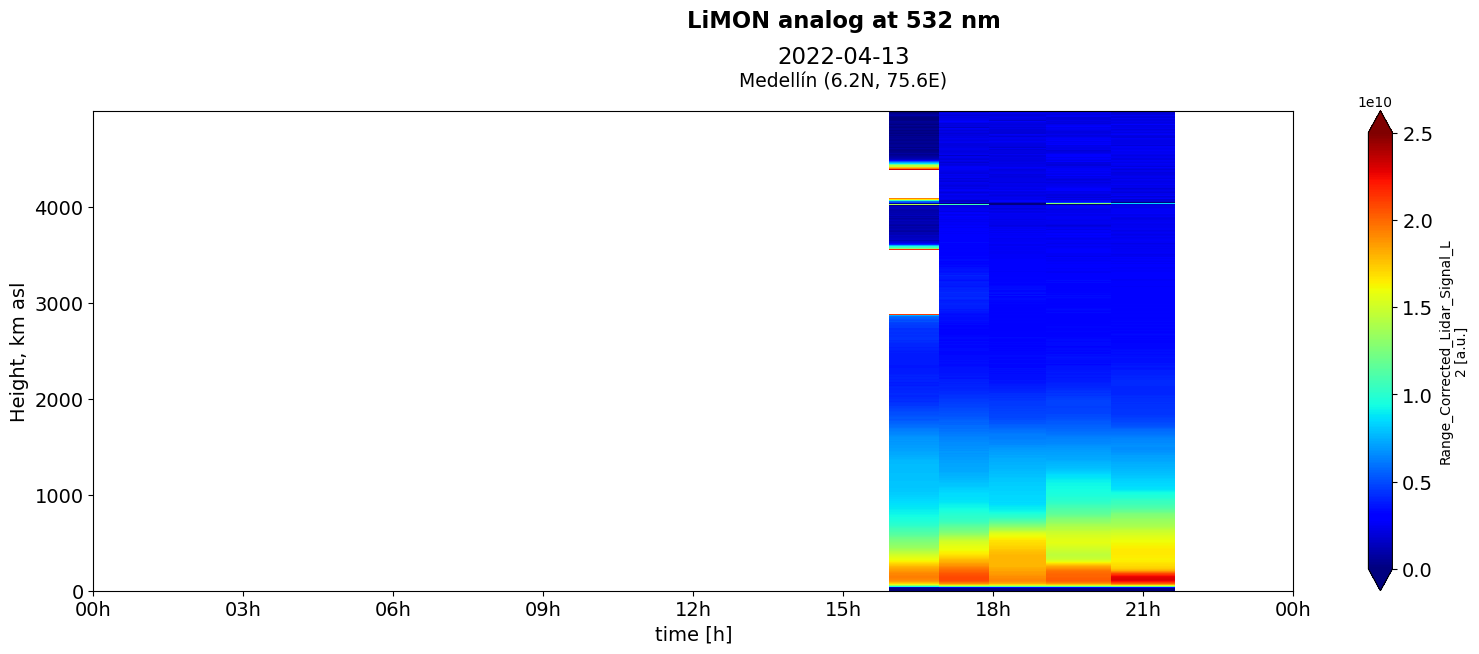

In [6]:
for filename in filenames:
  # ds = xr.load_dataset(filename)
  # ds = ds.assign_coords(range=ds.range/1000)

  ncfile = nc.Dataset(filename)
  group = ncfile.groups['L2_Data']
  ds = xr.open_dataset(xr.backends.NetCDF4DataStore(group))
  global_attributes = {attr: ncfile.getncattr(attr) for attr in ncfile.ncattrs()}

  start_time = ds.Start_Time_AVG_L2.values.astype('float32') // 10**9
  stop_time = ds.Stop_Time_AVG_L2.values

  avg_time = (start_time + stop_time) / 2

  datetime_ns = np.array(avg_time, dtype='datetime64[s]')
  datetime_ns = datetime_ns.astype('datetime64[ns]') 

  ds = ds.assign_coords(time=datetime_ns)

  qt = 'RCS'
  wl = '532'
  signal_mode = 'analog'
  channel = 'Range_Corrected_Lidar_Signal_L2'


  fig, axes = plt.subplots(nrows=1, figsize=(15,6))

  plot_as_me(ds, 
            channel, 
            axes, 
            qt, 
            wl,
            signal_mode, 
            attrs=global_attributes, 
            vmax=2.5e10,
            vmin=0,
            )

  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.set_xlabel('time [h]', fontsize=14)
  axes.set_ylabel('Height, km asl', fontsize=14)
  # year, month, day = str(ds.time[0].values.astype('datetime64[D]')).split('-') 
  # out_dir =  '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/output_dir/images'
  # fl_name = '{instru}_{qt}_{wl}_{mode}_mode_{y}{m}{d}.jpg'.format(instru=ds.attrs['system'], qt=qt, wl=wl, mode=signal_mode, y=year, m=month, d=day)
  # fl_name = os.path.join(out_dir, fl_name)
  # plt.savefig(fl_name, dpi=200)

In [5]:
filenames = ['/home/medico_eafit/WORKSPACES/sebastian_carmona/data/EAFIT/Dataset1/LiMon_Raw_Data_cc/2022/04/13/RS/LPP_OUT/RS_L0_L1_L2.nc']

# blh_human_path = '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/blh-from-human/'
# blh_lidar_path = '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/blh-from-lidar/'

In [6]:
for filename in filenames:
  date = filename.split('/')[-1].split('.')[0].split('_')[-1]

  ds = xr.load_dataset(filename)
  ds = ds.assign_coords(range=ds.range/1000)
  site = site_location(float(ds.lat.data[0]), float(ds.lon.data[0]))

  qt = 'RCS'
  wl = '532'
  signal_mode = 'analog'
  channel = 'rcs_0'


  fig, axes = plt.subplots(nrows=1, figsize=(15,6))

  plot_as_me(ds, 
            channel, 
            axes, 
            qt, 
            wl,
            signal_mode, 
            attrs=ds.attrs, 
            vmax=1,
            vmin=0,
            )
  blh_human_filename = glob.glob(blh_human_path + '*' + date + '*')[0]
  blh_human = pd.read_csv(blh_human_filename)
  blh_human.t_values = blh_human.t_values.apply(pd.Timestamp.fromtimestamp)

  blh_lidar_filename = glob.glob(blh_lidar_path + '*' + site + '*')[0]
  blh_lidar = xr.load_dataset(blh_lidar_filename, decode_times=False)
  blh_lidar.assign_coords(time=[pd.Timestamp.fromtimestamp(date) for date in blh_lidar.time.values])

  plt.scatter(blh_human.t_values, blh_human.blh_ref/1000, c='purple', s=None, marker='*', label='blh_human')
  # blh_lidar.plot.scatter(x='time', y='BLH_INDUS')
  # plt.scatter(blh_lidar.time, blh_lidar.BLH_INDUS)
  plt.legend(fontsize=14)
  # pdb.set_trace()
  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.set_xlabel('time [h]', fontsize=14)
  axes.set_ylabel('Height, km asl', fontsize=14)

AttributeError: 'Dataset' object has no attribute 'lat'

In [ ]:
blh_lidar = [pd.Timestamp.fromtimestamp(date) for date in blh_lidar.time.values]

# Gradient Methods

In [8]:
def gradient_method(ds, variable:str = 'rcs_0', method:str = 'first derivative', max_range:float = 5):
  if method == 'first derivative':
    rcs_gradient = ds[variable].sel(range=slice(0,max_range)).differentiate(coord='range')
    ablh = rcs_gradient.idxmin(dim='range')
    return ds.assign(ablh_gm1 = ablh)
  
  elif method == 'second derivative':
    rcs_gradient = ds[variable].sel(range=slice(0,max_range)).differentiate(coord='range').differentiate(coord='range')
    ablh = rcs_gradient.idxmin(dim='range')
    return ds.assign(ablh_gm2 = ablh)
  
  elif method == 'log derivative':
    log_variable = xr.apply_ufunc(np.log, ds[variable])
    rcs_gradient = log_variable.sel(range=slice(0,max_range)).differentiate(coord='range')
    ablh = rcs_gradient.idxmin(dim='range')
    return ds.assign(ablh_gmlog = ablh)
  
  elif method == 'cubic root derivative':
    cubic_root = xr.apply_ufunc(np.cbrt, ds[variable])
    rcs_gradient = cubic_root.sel(range=slice(0,max_range)).differentiate(coord='range')
    ablh = rcs_gradient.idxmin(dim='range')
    return ds.assign(ablh_gmcr = ablh)
  
  elif method == 'all':
    ds = gradient_method(ds=ds, variable=variable, method='first derivative', max_range=max_range)
    ds = gradient_method(ds=ds, variable=variable, method='second derivative', max_range=max_range)
    ds = gradient_method(ds=ds, variable=variable, method='log derivative', max_range=max_range)
    ds = gradient_method(ds=ds, variable=variable, method='cubic root derivative', max_range=max_range)
    return ds

In [7]:
filenames

['/home/medico_eafit/WORKSPACES/sebastian_carmona/data/EAFIT/Dataset1/LiMon_Raw_Data_cc/2022/04/13/RS/LPP_OUT/RS_L0_L1_L2.nc']

KeyError: "No variable named 'rcs_0'. Variables on the dataset include ['Raw_Lidar_Data', 'Raw_Data_Start_Time', 'Raw_Data_Stop_Time', 'Wavelengths', 'Polarization', ..., 'ADC_Bits', 'Laser_Source', 'nBins_Ch', 'File_Names', 'range']"

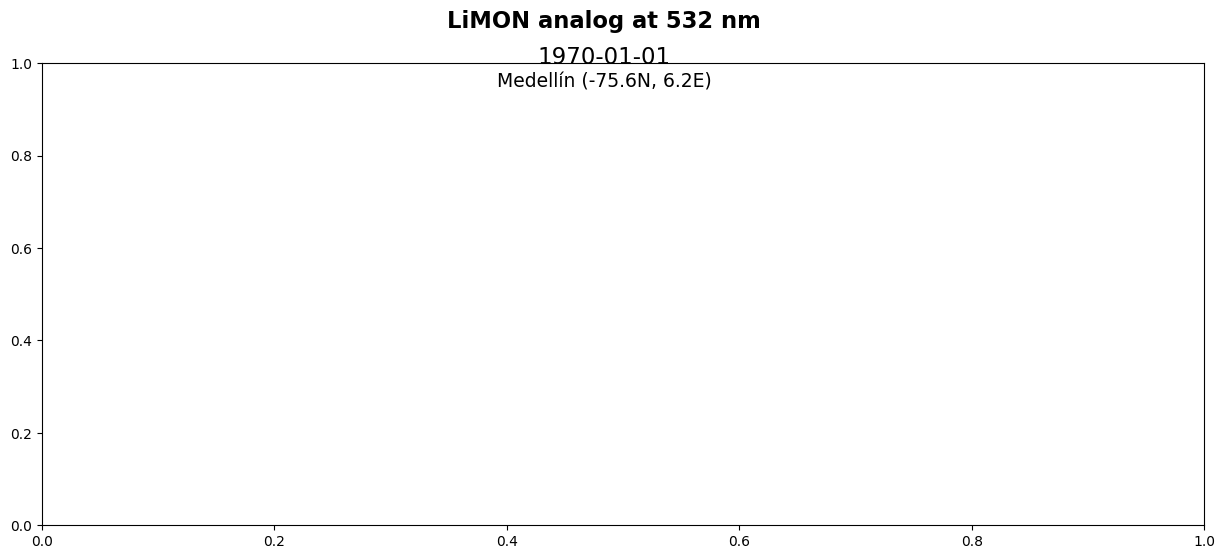

In [10]:
qt = 'RCS'
wl = '532'
signal_mode = 'analog'
channel = 'rcs_0'


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds, 
          channel, 
          axes, 
          qt, 
          wl,
          signal_mode, 
          attrs=ds.attrs, 
          vmax=1.2,
          vmin=0,
          )

axes.tick_params(axis='both', which='major', labelsize=14)
axes.tick_params(axis='both', which='minor', labelsize=14)
axes.tick_params(axis='both', which='major', labelsize=14)
axes.tick_params(axis='both', which='minor', labelsize=14)
axes.set_xlabel('time [h]', fontsize=14)
axes.set_ylabel('Height, km asl', fontsize=14)
# year, month, day = str(ds.time[0].values.astype('datetime64[D]')).split('-') 
# out_dir =  '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/Proyecto Avanzado II/Workbench/output_dir/images'
# fl_name = '{instru}_{qt}_{wl}_{mode}_mode_{y}{m}{d}.jpg'.format(instru=ds.attrs['system'], qt=qt, wl=wl, mode=signal_mode, y=year, m=month, d=day)
# fl_name = os.path.join(out_dir, fl_name)
# plt.savefig(fl_name, dpi=200)

In [ ]:
filenames = glob.glob('/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL*.nc')
filenames = ['/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5025_20180802.nc', 
             '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5029_20180224.nc']
filenames
blh_human_path = '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/blh-from-human/'


<class 'numpy.ndarray'>


/home/medico_eafit/.conda/envs/4DAir_LPP/lib/python3.11/site-packages/xarray/core/computation.py:821: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/medico_eafit/.conda/envs/4DAir_LPP/lib/python3.11/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/home/medico_eafit/.conda/envs/4DAir_LPP/lib/python3.11/site-packages/numpy/lib/function_base.py:1238: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/home/medico_eafit/.conda/envs/4DAir_LPP/lib/python3.11/site-packages/numpy/lib/function_base.py:1259: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
/home/medico_eafit/.conda/envs/4DAir_LPP/lib/python3.11/site-packages/numpy/lib/function_base.py:1266: RuntimeWarning: invalid value encountered in subtract
  out[tuple(sl

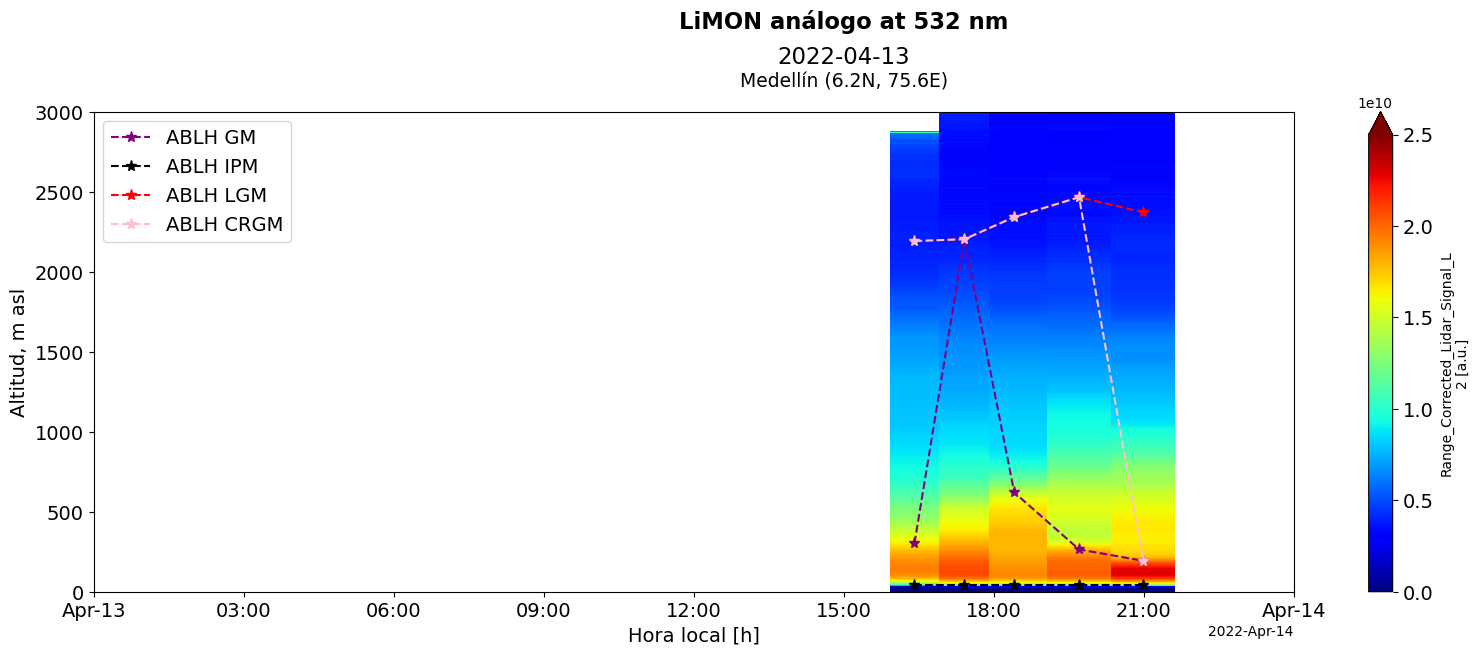

In [9]:
for filename in filenames:
  date = filename.split('/')[-1].split('.')[0].split('_')[-1]

  ncfile = nc.Dataset(filename)
  group = ncfile.groups['L2_Data']
  ds = xr.open_dataset(xr.backends.NetCDF4DataStore(group))
  global_attributes = {attr: ncfile.getncattr(attr) for attr in ncfile.ncattrs()}

  start_time = ds.Start_Time_AVG_L2.values.astype('float32') // 10**9
  stop_time = ds.Stop_Time_AVG_L2.values

  avg_time = (start_time + stop_time) / 2

  datetime_ns = np.array(avg_time, dtype='datetime64[s]')
  datetime_ns = datetime_ns.astype('datetime64[ns]') 

  ds = ds.assign_coords(time=datetime_ns)

  # site = site_location(float(ds.lat.data[0]), float(ds.lon.data[0]))

  qt = 'Señal corregida de rango'
  wl = '532'
  signal_mode = 'análogo'
  channel = 'Range_Corrected_Lidar_Signal_L2'


  fig, axes = plt.subplots(nrows=1, figsize=(15,6))

  plot_as_me(ds.sel(range=slice(0, 3000)), 
            channel, 
            axes, 
            qt, 
            wl,
            signal_mode, 
            attrs=global_attributes, 
            vmax=2.5e10,
            vmin=0,
            )

  ds = gradient_method(ds, variable=channel, max_range=2500, method='all')

  # blh_human_filename = glob.glob(blh_human_path + '*' + date + '*')[0]
  # blh_human = pd.read_csv(blh_human_filename)
  # blh_human.t_values = blh_human.t_values.apply(pd.Timestamp.fromtimestamp)
  # plt.plot(blh_human.t_values, blh_human.blh_ref/1000, c='red', marker='*', label='ablh_human')

  markersize = 8
  # pdb.set_trace()
  ds.ablh_gm1.sel(channels=0).plot(color='purple', linestyle='dashed', marker='*', markersize=markersize, mec=None, label='ABLH GM')
  ds.ablh_gm2.sel(channels=0).plot(color='black', linestyle='dashed', marker='*', markersize=markersize, mec=None, label='ABLH IPM')
  ds.ablh_gmlog.sel(channels=0).plot(color='red', linestyle='dashed', marker='*', markersize=markersize, mec=None, label='ABLH LGM')
  ds.ablh_gmcr.sel(channels=0).plot(color='pink', linestyle='dashed', marker='*', markersize=markersize, mec=None, label='ABLH CRGM')
  

  plt.legend(fontsize=14)
  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.set_xlabel('Hora local [h]', fontsize=14)
  axes.set_ylabel('Altitud, m asl', fontsize=14)

  # fig.savefig('/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Figuras para Tesis/GM_{}.jpg'.format(str(ds.time.values[0].astype('datetime64[D]'))), bbox_inches='tight', dpi=250)

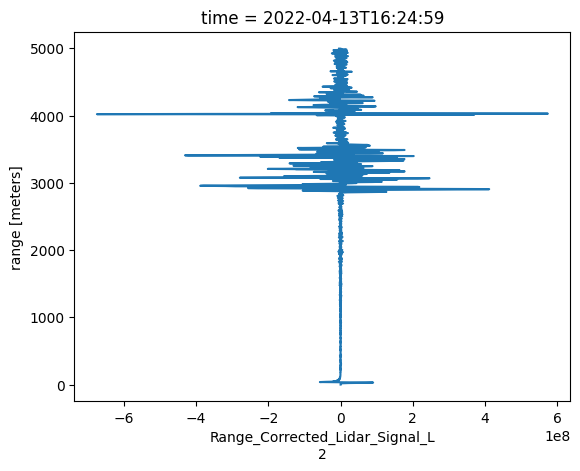

In [39]:
variable = 'Range_Corrected_Lidar_Signal_L2'
max_range = 5000
ds[variable].sel(range=slice(0,max_range)).differentiate(coord='range').differentiate(coord='range').sel(channels=0, time='2022-04-13T16:24:59.000000000').plot(y="range")

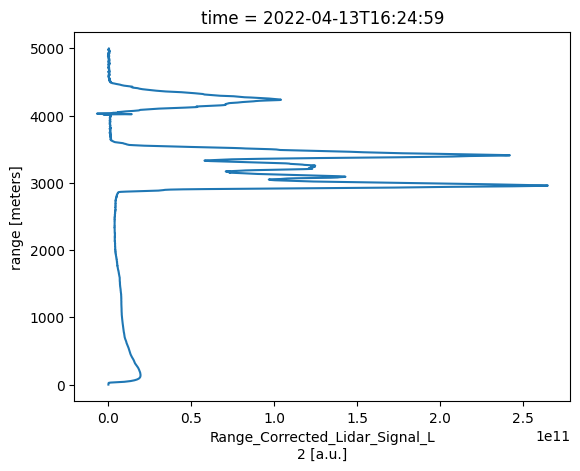

In [37]:
ds[variable].sel(range=slice(0,5000)).sel(channels=0, time='2022-04-13T16:24:59.000000000').plot(y="range")

In [31]:
ds.ablh_gm1.sel(channels=0).time

<xarray.DataArray 'time' (time: 5)> Size: 40B
array(['2022-04-13T16:24:59.000000000', '2022-04-13T17:24:52.000000000',
       '2022-04-13T18:24:44.000000000', '2022-04-13T19:42:28.000000000',
       '2022-04-13T20:59:31.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 40B 2022-04-13T16:24:59 ... 2022-04-13T20:...

# Fitting Erf function

In [ ]:
import numpy as np
from scipy.special import erf
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


In [ ]:
filenames = glob.glob('/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL*.nc')
filenames = ['/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5025_20180802.nc', 
             '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5029_20180224.nc']
filenames

['/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5025_20180802.nc',
 '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5029_20180224.nc']

In [ ]:
ds = xr.load_dataset(filenames[1])
ds = ds.assign_coords(range=ds.range/1000)
ds

<xarray.Dataset>
Dimensions:                           (time: 288, range: 664, range_raw: 1000, range_vbp: 197, layer: 10)
Coordinates:
  * time                              (time) datetime64[ns] 2018-02-24 ... 20...
  * range                             (range) float32 0.1199 0.1499 ... 20.0
  * range_raw                         (range_raw) float32 29.98 ... 2.998e+04
  * range_vbp                         (range_vbp) float32 119.9 ... 5.996e+03
  * layer                             (layer) int32 0 1 2 3 4 5 6 7 8 9
Data variables: (12/59)
    rcs_0                             (time, range) float64 0.9312 ... -0.01924
    bckgrd_rcs_0                      (time) float64 0.0007046 ... 0.0006287
    rcs_1                             (time, range) float64 0.9101 ... -0.002202
    bckgrd_rcs_1                      (time) float64 0.0004331 ... 0.0003885
    rcs_2                             (time, range) float64 0.02102 ... -0.01704
    bckgrd_rcs_2                      (time) float64 0.0007046 ... 0.0006287
    ...                                ...
    rr                                (time) int32 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
    ablh_gm1                          (time) float32 569.6 569.6 ... 899.4 869.4
    ablh_gm2                          (time) float32 509.6 509.6 ... 839.4 839.4
    ablh_gmlog                        (time) float32 629.6 629.6 ... 899.4 869.4
    ablh_gmcr                         (time) float32 569.6 599.6 ... 899.4 869.4
    ablh_fit                          (time) float64 408.0 437.5 ... 722.2 714.7
Attributes: (12/14)
    site_location:                Name of measurement station
    instrument_id:                MiniMPL
    institution:                  The institution or Met Service operating th...
    principal_investigator:       Department responsible for the instrument
    instrument_type:              Mini-MPL
    title:                        the site name and instrument type and manuf...
    ...                           ...
    overlap_function:             False
    overlap_is_corrected:         True
    source:                       SIRTA & UK Met Office
    references:                   
    comment:                      
    Conventions:                  CF-1.0, UKMO-1.0.2

In [ ]:
filenames = glob.glob('/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/CEDA/FRANCE/BREST/2018/**/*.nc', recursive=True) # CEDA
len(filenames)

82

In [9]:
def erfunc(x, A2, zm, s, A1):
    return -A2*erf((x-zm)/(s)) + A1

def fit_ufunc(profile, range, p0=None):
  try:
    # pdb.set_trace()
    params, extras = curve_fit(f=erfunc, xdata=range, ydata=profile, p0=p0)
    return erfunc(range, *params), params[1]
    # return params[1]
  except:
    # return np.ceros(profile.shape)
    return None, 0

def fitting(ds, variable, max_range=2.5):
  Bu0 = ds.sel(altitude=slice(max_range, ds.altitude.max().values))[variable].mean().values
  Bm0 = ds.sel(altitude=slice(0, max_range/2))[variable].mean().values
  A10 = (Bm0 + Bu0)/2
  A20 = (Bm0 - Bu0)/2
  zm0 = max_range / 4
  s0 = max_range / 10

  # pdb.set_trace()
  fit= np.apply_along_axis(fit_ufunc, 1, ds[variable].sel(altitude=slice(0, max_range)).values.T, ds.altitude.sel(altitude=slice(0, max_range)).values, p0=[A20, zm0, s0, A10])
  ablh = fit[:,1].astype(float)

  ablh[ablh<=0] = np.nan
  ablh[ablh>max_range] = np.nan
  ablh = xr.DataArray(data=ablh, 
                      dims=["time"], 
                      attrs=dict(description="ABLH from an erf function fitted"),
                      coords=dict(
                                  time=(['time'], ds.time.values),
                              ),
                      )
  # pdb.set_trace()
  ds = ds.assign(ablh_fit = ablh)

  # return fit[:,0], fit[:,1]
  return ds

In [8]:
for filename in [filenames[9]]:
  date = filename.split('/')[-1].split('.')[0].split('_')[-1]
  ds = xr.load_dataset(filename)
  ds.attenuated_backscatter_0.attrs['long_name'] = 'Coeficiente de retroesparcimiento \natenuado a 532 nm'

  max_range = 2500
  # site = site_location(float(ds.lat.data[0]), float(ds.lon.data[0]))
  # pdb.set_trace()
  qt = 'RCS'
  wl = '532'
  signal_mode = 'Coef. retroesparcimiento atenuado'
  channel = 'attenuated_backscatter_0'
  pfl_n = 150
  time_stamp = ds.time[pfl_n]

  

  fig, axes = plt.subplots(nrows=1, figsize=(24,8))
  
  ax1 = plt.subplot(1,6,(1))
  ax2 = plt.subplot(1,6,(2,6), sharey=ax1)
  # pdb.set_trace()
  

  plot_as_me(ds.sel(altitude=slice(0, max_range)), 
            channel, 
            axes=ax2, 
            qt=qt, 
            wl=wl,
            signal_mode=signal_mode, 
            attrs=ds.attrs, 
            vmax=(ds.calibration_constant_0.mean()/1.5e4).values,
            vmin=0,
            coef=1.2,
            )


  ds[channel].sel(time=time_stamp, method='nearest').sel(altitude=slice(0, max_range)).plot(y='altitude', ax=ax1)


  # blh_human_filename = glob.glob(blh_human_path + '*' + date + '*')[0]
  # blh_human = pd.read_csv(blh_human_filename)
  # blh_human.t_values = blh_human.t_values.apply(pd.Timestamp.fromtimestamp)
  # plt.scatter(blh_human.t_values, blh_human.blh_ref, axes=ax2, c='red', s=200, marker='*', edgecolor='black', linewidth=1, label='ABLH visual')
  # blh_human = xr.DataArray(data=blh_human.blh_ref, dims=['time'], coords=dict(time=blh_human.t_values))
  # ax1.scatter(ds[channel].sel(time=time_stamp, altitude=blh_human.sel(time=time_stamp, method='nearest'), method='nearest').values, 
  # blh_human.sel(time=time_stamp, method='nearest'), axes=ax1, c='red', s=500, marker='*', edgecolor='black', linewidth=2)


  # ds = gradient_method(ds, variable=channel, max_range=2500, method='all')

  markersize = 14
  # ds.ablh_gm1.plot(c='magenta', linestyle='dashed', marker='*', markersize=markersize, mec='black', label='ABLH GM1')
  # ds.ablh_gm2.plot(c='black', linestyle='dashed', marker='*', markersize=markersize, mec=None, label='ablh GM2')
  # ds.ablh_gmlog.plot(c='green', linestyle='dashed', marker='*', markersize=markersize, mec=None, label='ablh GMlog')
  # ds.ablh_gmcr.plot(c='pink', linestyle='dashed', marker='*', markersize=markersize, mec=None, label='ablh GMcb')

  ds = fitting(ds, variable=channel, max_range=max_range)
  
  ds.to_netcdf(filename, mode='a')
  ds.ablh_fit.plot(c='pink', linestyle='dashed', marker='*', markersize=markersize, mec='black', label='ABLH ajuste de curva')
  ax1.scatter(ds[channel].sel(time=time_stamp, altitude=ds.ablh_fit.sel(time=time_stamp), method='nearest').values, ds.ablh_fit.sel(time=time_stamp), 
              s=500, c='pink', marker='*', edgecolor='black', linewidth=2, label='ABLH Radiosonda')
  # ax1.scatter(ds[channel].sel(time=time_stamp, altitude=ds.ablh_gm1.sel(time=time_stamp), method='nearest').values, ds.ablh_gm1.sel(time=time_stamp), 
  #             s=500, c='magenta', marker='*', edgecolor='black', linewidth=2, label='ABLH Radiosonda')
  
  # plt.plot(ablh)

  
  plt.legend(fontsize=14)
  # pdb.set_trace()
  ax1.tick_params(axis='both', which='major', labelsize=20)
  ax1.tick_params(axis='both', which='minor', labelsize=20)
  ax2.tick_params(axis='both', which='major', labelsize=20)
  ax2.tick_params(axis='both', which='minor', labelsize=20)
  ax2.set_xlabel('Hora local [h]', fontsize=20)
  ax2.set_ylabel('', fontsize=20)
  ax1.set_ylabel('Altitud, m asl', fontsize=20)
  ax1.set_xlabel('Coef. de \nretroesparcimiento \natenuado', fontsize=20)
  ax1.set_title('Perfil a las {}h'.format(str(time_stamp.values.astype('datetime64[m]'))[-5:]), fontsize=20)
  o_ = plt.setp(ax2.get_yticklabels(), visible=False)

  endTime = ds.time[pfl_n].values + np.timedelta64(1, 's')
  start = mpl.dates.date2num(ds.time[pfl_n].values)
  end = mpl.dates.date2num(endTime)
  width = end - start
  rect = mpl.patches.Rectangle((start, 0), width, 2500, linewidth=2,color='red',fill=False)

  ax2.add_patch(rect)

  plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.82,
                    wspace=0.2,
                    hspace=0.4)

IndexError: list index out of range

In [ ]:
filename = '/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL_5029_20180224.nc'

<class 'numpy.ndarray'>


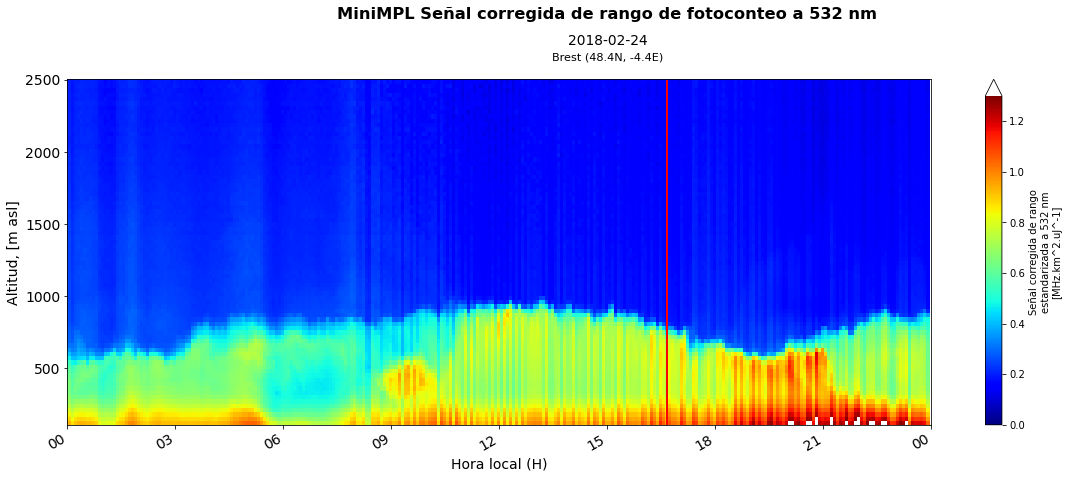

In [ ]:
date = filename.split('/')[-1].split('.')[0].split('_')[-1]

ds = xr.load_dataset(filename)
# ds = ds.assign_coords(range=ds.range/1000)
site = site_location(float(ds.lat.data[0]), float(ds.lon.data[0]))

qt = 'Señal corregida de rango'
wl = '532'
signal_mode = 'fotoconteo'
channel = 'rcs_0'


fig, axes = plt.subplots(nrows=1, figsize=(15,6))

plot_as_me(ds.sel(range=slice(0, 2500)), 
          channel, 
          axes, 
          qt, 
          wl,
          signal_mode, 
          attrs=ds.attrs, 
          vmax=1.3,
          vmin=0,
          )


blh_human_filename = glob.glob(blh_human_path + '*' + date + '*')[0]
blh_human = pd.read_csv(blh_human_filename)
blh_human.t_values = blh_human.t_values.apply(pd.Timestamp.fromtimestamp)
# plt.plot(blh_human.t_values, blh_human.blh_ref/1000, c='red', marker='*', label='ablh_human')

# ds = gradient_method(ds, variable='rcs_0', max_range=2500, method='all')

markersize = 9
# ds.ablh_gm1.plot(c='purple', linestyle='dashed', marker='*', markersize=markersize, mec=None, label='ablh GM1')
# ds.ablh_gm2.plot(c='black', linestyle='dashed', marker='*', markersize=markersize, mec=None, label='ablh GM2')
# ds.ablh_gmlog.plot(c='green', linestyle='dashed', marker='*', markersize=markersize, mec=None, label='ablh GMlog')
# ds.ablh_gmcr.plot(c='pink', linestyle='dashed', marker='*', markersize=markersize, mec=None, label='ablh GMcb')

max_range = 2.5
ds = fitting(ds, variable='rcs_0')
# ds.ablh_fit.plot(c='pink', linestyle='dashed', marker='*', markersize=markersize, mec='black', label='ablh fit')

# plt.plot(ablh)


# plt.legend(fontsize=14)
# pdb.set_trace()
axes.tick_params(axis='both', which='major', labelsize=14)
axes.tick_params(axis='both', which='minor', labelsize=14)
axes.set_xlabel('Hora local (H)', fontsize=14)
axes.set_ylabel('Altitud, [m asl]', fontsize=14)

# pdb.set_trace()
endTime = ds.time[200].values + np.timedelta64(1, 's')
start = mpl.dates.date2num(ds.time[200].values)
end = mpl.dates.date2num(endTime)
width = end - start
rect = mpl.patches.Rectangle((start, 0), width, 2500, linewidth=2,color='red',fill=False)

axes.add_patch(rect)


In [ ]:
ds

<xarray.Dataset>
Dimensions:                          (time: 288, altitude: 663, layer: 3)
Coordinates:
  * time                             (time) datetime64[ns] 2018-10-20T00:05:0...
  * altitude                         (altitude) float64 213.4 ... 2.007e+04
Dimensions without coordinates: layer
Data variables: (12/19)
    start_time                       (time) datetime64[ns] 2018-10-15T00:05:0...
    latitude                         (altitude, time) float64 nan nan ... nan
    longitude                        (altitude, time) float64 nan nan ... nan
    attenuated_backscatter_0         (altitude, time) float64 5.615 ... 0.2927
    uncertainties_att_backscatter_0  (altitude, time) float64 1.404 ... 0.07317
    l0_wavelength                    float64 532.0
    ...                               ...
    calibration_constant_0           (time) float64 1.688e+05 ... 1.688e+05
    ablh_gm1                         (time) float64 393.4 363.4 ... 303.4 213.4
    ablh_gm2                         (time) float64 363.4 333.4 ... 273.4 273.4
    ablh_gmlog                       (time) float64 393.4 363.4 ... 303.4 303.4
    ablh_gmcr                        (time) float64 393.4 363.4 ... 303.4 213.4
    ablh_fit                         (time) float64 347.5 319.4 ... 275.5 217.5
Attributes: (12/18)
    site_location:                BREST,FRANCE
    instrument_id:                A
    wigos_station_id:             0-20000-0-07110
    wmo_id:                       07110
    instrument_serial_number:     5029
    instrument_firmware_version:  Unknown
    ...                           ...
    institution:                  MeteoFrance Remote Sensing Group
    source:                       Ground Based Remote Sensing
    references:                   E-PROFILE Data Format Description Document
    comment:                      
    Convention:                   CF-1.6, UKMO-1.0.2
    instrument_type:              Mini-MPL

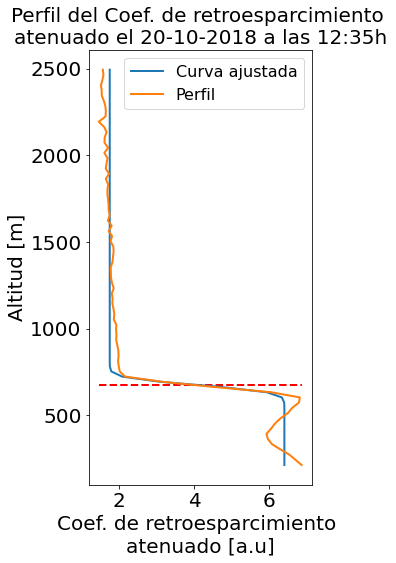

In [ ]:
# fitted, params = fit_ufunc(ds.rcs_0[10] / ds.range**2, max_range=1)

fig = plt.figure(figsize=(4,8))
Bu0 = ds.sel(altitude=slice(max_range, ds.altitude.max().values))[channel].mean().values
Bm0 = ds.sel(altitude=slice(0, max_range/2))[channel].mean().values
A10 = (Bm0 + Bu0)/2
A20 = (Bm0 - Bu0)/2
zm0 = max_range / 4
s0 = max_range / 10

p0=[A20, zm0, s0, A10]

# pdb.set_trace()
fitted, zm_ = fit_ufunc(ds[channel][:, pfl_n].sel(altitude=slice(0, 2500)).values, ds.altitude.sel(altitude=slice(0,2500)).values, p0=p0)
plt.plot([(ds[channel][:, pfl_n]).sel(altitude=slice(0,2500)).min(), (ds[channel][:, pfl_n]).sel(altitude=slice(0,2500)).max()], [zm_, zm_], '--', lw=2, color='red')
plt.plot(fitted, ds.altitude.sel(altitude=slice(0,2500)), label='Curva ajustada', lw=2)
(ds[channel][:, pfl_n]).sel(altitude=slice(0,2500)).plot(y='altitude', label='Perfil', lw=2)


plt.ylabel('Altitud [m]', fontsize=20)
plt.xlabel('Coef. de retroesparcimiento \natenuado [a.u]', fontsize=20)
plt.title('Perfil del Coef. de retroesparcimiento \natenuado el 20-10-2018 a las 12:35h', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=20)


plt.legend(fontsize=16)

In [ ]:
zm_

0.8163857496352029

In [ ]:
ds.range.sel(range=slice(0,1))
A2, zm, s, A1 = 70, 0, 4e-1, 70

y_data = erfunc(ds.range.sel(range=slice(0,1)), A2, zm, s, A1)

params, extras = curve_fit(erfunc, ds.range.sel(range=slice(0,1)).values, (ds.rcs_0[10] / ds.range**2).sel(range=slice(0, 1)).values)

plt.plot(y_data, ds.range.sel(range=slice(0,1)), label='ideal profile before fitting')
(ds.rcs_0[10] / ds.range**2).sel(range=slice(0, 1)).plot(y='range', label='lidar signal profile')
plt.plot(erfunc(ds.range.sel(range=slice(0,1)), *params), ds.range.sel(range=slice(0,1)), label='ideal profile after fitting')

plt.legend()



ValueError: ignored

In [ ]:
params, extras

NameError: ignored

In [ ]:
ds.raw_signal_1.sel(range_raw=slice(0, 1000)).plot.pcolormesh(x='time', cmap='jet')
plt.show()
(ds.rcs_0 / ds.range**2).sel(range=slice(0, 1)).plot.pcolormesh(x='time', cmap='jet')

In [ ]:
ds

In [ ]:
filenames = glob.glob('/content/drive/MyDrive/TRABAJO DE GRADO - SCE/TFG/Datos de autores/kabl-master (Thomas Rieutord)/data-samples/lidar/DAILY_MPL*.nc')

<class 'numpy.ndarray'>


NameError: ignored

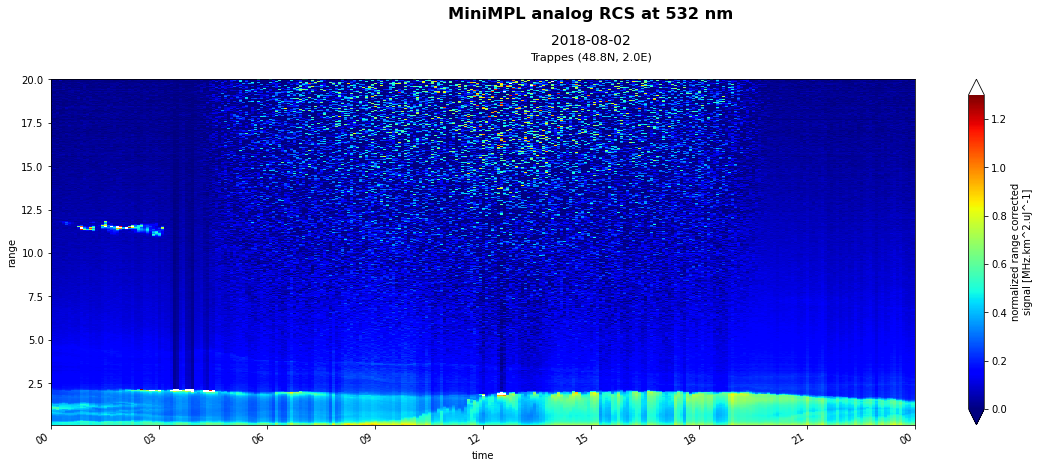

In [ ]:
for filename in filenames:
  date = filename.split('/')[-1].split('.')[0].split('_')[-1]

  ds = xr.load_dataset(filename)
  ds = ds.assign_coords(range=ds.range/1000)
  site = site_location(float(ds.lat.data[0]), float(ds.lon.data[0]))

  qt = 'RCS'
  wl = '532'
  signal_mode = 'analog'
  channel = 'rcs_0'


  fig, axes = plt.subplots(nrows=1, figsize=(15,6))

  plot_as_me(ds, 
            channel, 
            axes, 
            qt, 
            wl,
            signal_mode, 
            attrs=ds.attrs, 
            vmax=1.3,
            vmin=0,
            )


  # blh_human_filename = glob.glob(blh_human_path + '*' + date + '*')[0]
  # blh_human = pd.read_csv(blh_human_filename)
  # blh_human.t_values = blh_human.t_values.apply(pd.Timestamp.fromtimestamp)
  # plt.plot(blh_human.t_values, blh_human.blh_ref/1000, c='red', marker='*', label='blh_human')

  ds = gradient_method(ds, variable='rcs_0', max_range=2.5, method='all')

  markersize = 9
  ds.ablh_gm1.plot(c='purple', linestyle='dashed', marker='*', markersize=markersize, mec=None, label='ablh GM1')
  ds.ablh_gm2.plot(c='black', linestyle='dashed', marker='*', markersize=markersize, mec=None, label='ablh GM2')
  ds.ablh_gmlog.plot(c='green', linestyle='dashed', marker='*', markersize=markersize, mec=None, label='ablh GMlog')
  ds.ablh_gmcr.plot(c='pink', linestyle='dashed', marker='*', markersize=markersize, mec=None, label='ablh GMcb')

  max_range = 2.5
  ds = fitting(ds, variable='rcs_0')
  ds.ablh_fit.plot(c='pink', linestyle='dashed', marker='*', markersize=markersize, mec='black', label='ablh fit')

  # plt.plot(ablh)

  plt.legend(fontsize=14)
  # pdb.set_trace()
  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.tick_params(axis='both', which='major', labelsize=14)
  axes.tick_params(axis='both', which='minor', labelsize=14)
  axes.set_xlabel('time [h]', fontsize=14)
  axes.set_ylabel('Height, km asl', fontsize=14)